### LoopFlopy Example 2 - 3D Model

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

print(loopflopy.__file__)
modules = utils.list_modules(loopflopy)
for module in modules: 
    print(module)

c:\users\00105295\projects\loopflopy\loopflopy\__init__.py
dem
disv2disu
flowmodel
flowmodel_routines
geomodel
geomodel2
geomodel_routines
mesh
mesh_routines
modelling_routines_old
observations
project
properties
properties2
spatial
spatial_routines
structuralmodel
surfacerefinement
utils


### 1. Setup Project

In [2]:
# Project setup
name = 'example'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe_name = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe_name)
project.crs = 28350  # UTM zone 50S, EPSG:28350

### 3. Spatial

In [3]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)
spatial.x0, spatial.x1, spatial.y0, spatial.y1

(349088.0373017123, 392718.4692868978, 6507368.199997337, 6546515.9098643325)

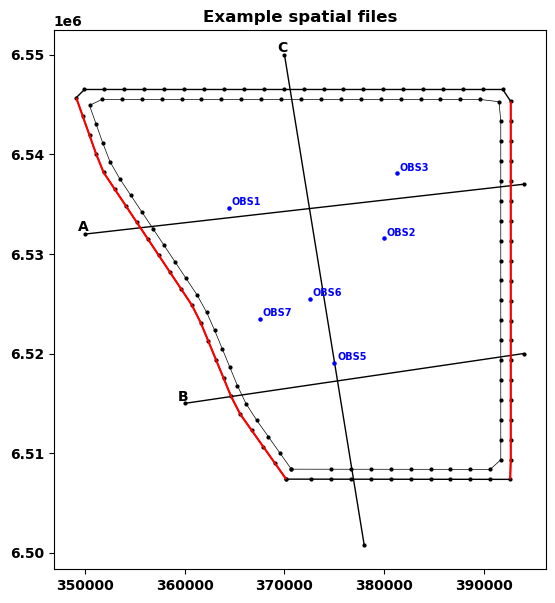

In [7]:
process_spatial.obs_bores(spatial)
process_spatial.geo_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)

spatial.xsection_names = ['A', 'B', 'C']
spatial.xsections = [
                     [(350000, 6532000),(394000, 6537000)], 
                     [(360000, 6515000),(394000, 6520000)],
                     [(370000, 6550000),(378000, 6500800)]
                     ]

process_spatial.plot_spatial(spatial, 
                             obsbores = True, 
                             pilotpoints = True,
                             pumpbores = False, 
                             geobores = False, 
                             xsections = True, 
                             fault = False)

In [8]:
# Create a map
m = spatial.obsbore_gdf.explore(location=[-31.4, 115.8], zoom_start=10, popup = 'id')
spatial.model_boundary_gdf.explore(m=m, fill = False)
spatial.faults_gdf.explore(m=m, color = 'red')
spatial.pumpbore_gdf.explore(m=m, color = 'red', popup = 'id')

### 3. Structural Model

In [9]:
# A bounding box for structural model
x0, x1 = 348000, 400000
y0, y1 = 6500000, 6550000
z0, z1 = -1000, 300
bbox = [(x0, y0, z0), (x1, y1, z1)]

from loopflopy.spatial_routines import make_bbox_shp
crop_polygon = make_bbox_shp(x0, x1, y0, y1, crs=project.crs, fname = '../data/shp/structuralmodel.shp')

geodata_fname = '../data/example_data.xlsx'
data_sheetname = 'geo_bores'
strat_sheetname = 'strat'

from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structural
process_structural.prepare_strat_column(structuralmodel)
process_structural.prepare_geodata(structuralmodel, spatial, Fault = False)
process_structural.create_structuralmodel(structuralmodel, Fault = False)

structuralmodel.faults = ['Fault']
#structuralmodel.data

['Ground', 'TQ', 'Kcok', 'Kwlp', 'Kwlw', 'Kwlm']
['Ground', 'TQ', 'Kcok', 'Leed']
1.6.13


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


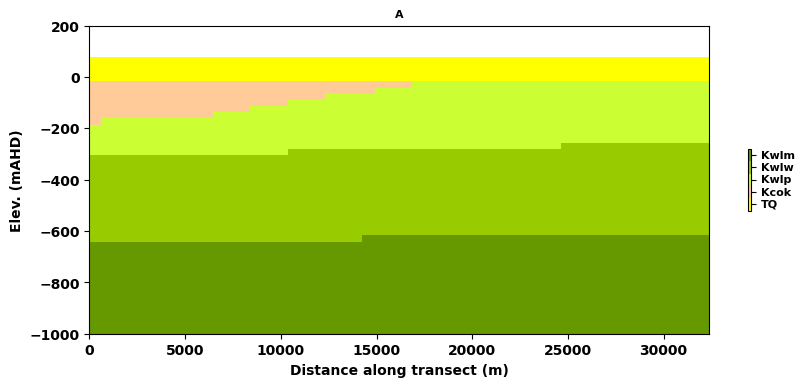

<Figure size 640x480 with 0 Axes>

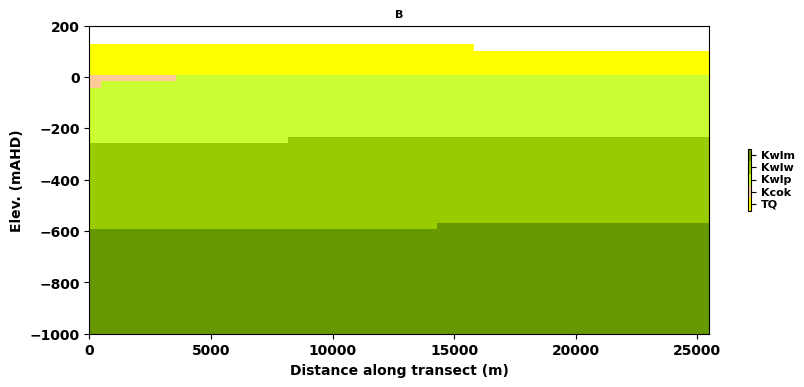

<Figure size 640x480 with 0 Axes>

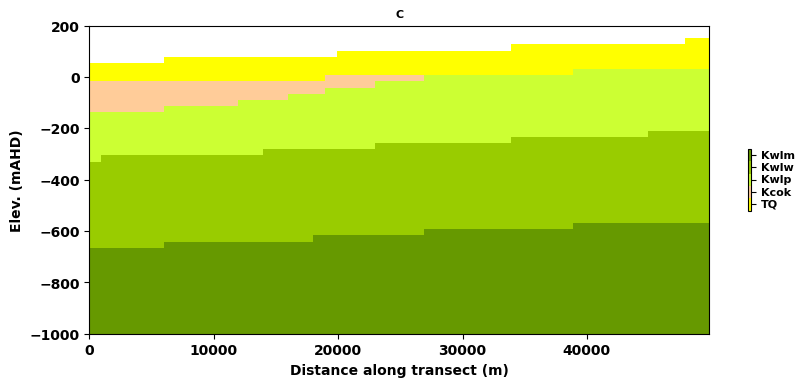

<Figure size 640x480 with 0 Axes>

In [7]:
z0 = -1000 # just for plotting. Make sure within bbox of structural model
z1 = 200   # just for plotting. Make sure within bbox of structural model
nh, nz = 50, 50 # plotting resolution

for i in range(len(spatial.xsections)):
    start = spatial.xsections[i][0]
    end   = spatial.xsections[i][1]

    structuralmodel.plot_xytransect(title = spatial.xsection_names[i], start = start, end = end, z0 = z0, z1 = z1, nh = nh, nz = nz)

['Ground', 'TQ', 'Kcok', 'Leed']


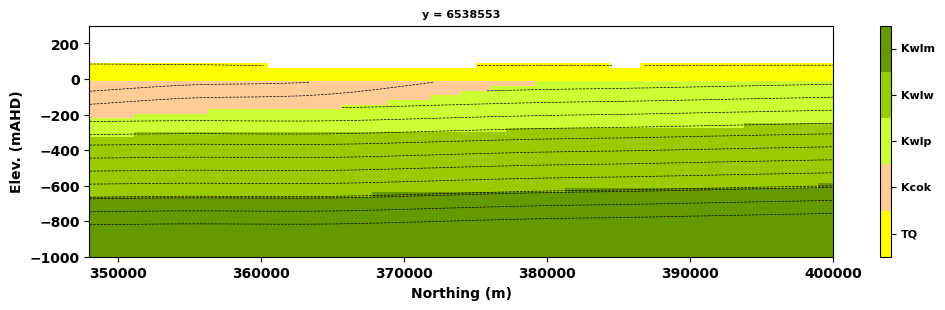

In [8]:
#transect_y = [6512553] 
transect_y = [6538553] 
structuralmodel.plot_ytransects2(transect_y, nx = 50, nz = 50, dz = 80)#, faults = False,
#structuralmodel.plot_ytransects(transect_y, nx = 50, nz = 50)#, z0 = -1200, z1 = 200) 
#structuralmodel.data

In [9]:
# Plot transects
structuralmodel.faults = ['Fault']
transect_x = [380000]
transect_y = [6538553] 
#structuralmodel.plot_xtransects(transect_x, ny = 80, nz = 80)#, x1 = 6520000, z0 = -2000) 
#structuralmodel.plot_ytransects(transect_y, nx = 80, nz = 80)#, z0 = -1200, z1 = 200) 

#structuralmodel.strat 
#structuralmodel.strat_col 
#structuralmodel.strat_names 
#structuralmodel.cmap
#structuralmodel.norm 
#structuralmodel.data

### 4. Meshing

In [24]:
# Create mesh object
from loopflopy.mesh import Mesh
special_cells = {
                 'chd': ['east', 'west'], 
                 'wel': ['pumpbores'], 
                 'obs': ['obsbores'], 
                 }
mesh = Mesh(plangrid = 'vor', special_cells = special_cells) # special cells to identify as arguements 

In [25]:
# Define mesh parameters and create mesh
mesh.modelmaxtri = 3000000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 400 # 50, 200 radius of inner circle around pumping bores
mesh.radius2 = 800 # 200, 600 radius of outer circle around pumping bores
mesh.boremaxtri = 99999999
mesh.ncol, mesh.nrow = 50, 50

mesh.create_bore_refinement(spatial)

node_list = ['bore_refinement_nodes',] # 'fault_nodes', 
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

Creating bore refinement nodes for pumping bores
bore_refinement_nodes
Creating Voronoi grid
number of cells in plan =  681


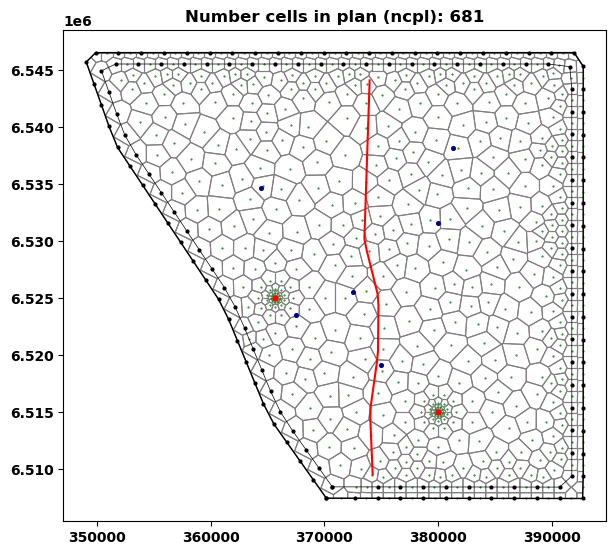

In [26]:
xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

features = ['wel', 'obs', 'fault']#,'river']
mesh.plot_cell2d(spatial, features, xlim = xlim, ylim = ylim)

### 5. Find Cell IDs of spatial features

Group =  chd ['east', 'west']
flag = 1
chd_east_cells [64 228 63 230 62 231 61 237 60 233 59 235 58 240 57 241 56 245 55 243 54
 252 53 247 52 249 51 254 50 255 49 261 48 257 47 259 46 264 45]
chd_west_cells [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Group =  wel ['pumpbores']
flag = 3
Group =  obs ['obsbores']
flag = 4
[0 1 2 3 4]
[0 1 2 3 4]


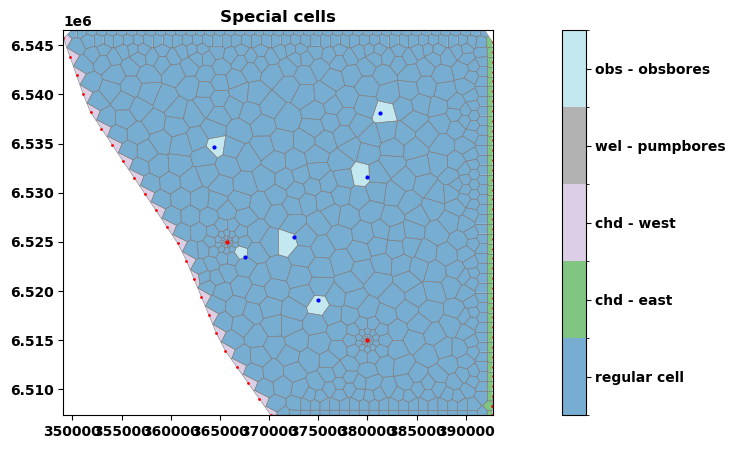

In [27]:
# Locate special cells and plot
mesh.locate_special_cells(spatial)

xlim = [355000, 370000]
ylim = [6525000, 6535000]

mesh.plot_feature_cells(spatial, xlim = None, ylim = None)

### 5. Geomodel

In [64]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -1000, 200 
surface = z1 * np.ones((mesh.ncpl), dtype=float) # empty array to fill in ground surface

from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 2, res = 3) # surfaces calculated at a 3m resolution

geomodel.evaluate_structuralmodel(mesh, structuralmodel)
geomodel.create_model_layers(mesh, structuralmodel, surface)
geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)

   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  1.364214
   1. Evaluating structural model...
len(xyz) =  1000000
Time taken Block 1 (Evaluate model) =  15.448687
   2. Creating geo model layers...
stop_array shape (6, 2500)
nlay =  400
ncpl =  2500
nlg number of geo layers =  5
Time taken Block 2 create geomodel layers  0.133032
   3. Evaluating geo layer thicknesses...
Time taken Block 3 tiny bit 0.000248
   4. Creating flow model layers...
Time taken Block 4 create flow model layers =  0.006943
   5. Calculating gradients...
Time taken Block 5 gradients=  0.739906


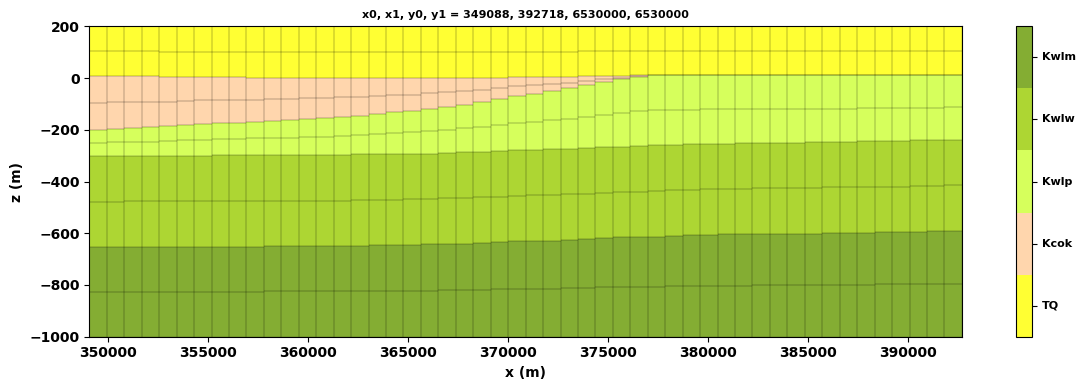

In [65]:
y0, y1 = 6530000, 6530000
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1)# z0 = -200, z1 = 300

In [66]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'properties')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = props.iconvert.tolist()
geomodel.fill_cell_properties(mesh)
props

   6. Filling cell properties...
ang1 shape  (10, 2500)
23184
angle1 shape  (23184,)
Time taken Block 6 Fill cell properties =  0.002451


,index,unit,hk,vk,ss,sy,iconvert
0,1,TQ,50.0,5.0,0.0001,0.1,1.0
1,2,Kcok,5.0,5.0,0.0001,0.1,0.0
2,3,Kwlp,50.0,50.0,0.0001,0.1,0.0
3,4,Kwlw,50.0,50.0,0.0001,0.1,0.0
4,5,Kwlm,100.0,100.0,0.0001,0.1,0.0


### 6. Prepare Data for Flowmodel

In [67]:
from process_data import Data
data = Data()

data.process_ic()#geomodel)
data.process_rch(geomodel, mesh)
data.process_chd(spatial, geomodel, mesh)

wel_q = [-100000, 0]
wel_qlay= [0, 0]
data.process_wel(geomodel, mesh, spatial, wel_q, wel_qlay)


Well screens  [(np.float64(-1000.0), np.float64(26.0)), (np.float64(-1000.0), np.float64(8.0))]


In [68]:
from loopflopy.observations import Observations
import process_observations

df = pd.read_excel('../data/example_data.xlsx', sheet_name='obs_bores')
observations = Observations(df)
observations.gdf = process_observations.make_obs_gdf(df, geomodel, mesh, spatial)
observations.gdf

The following geometries are NOT within the polygon:
     id         x        y    z                geometry
3  OBS4  367845.0  6510204 -500  POINT (367845 6510204)


,id,x,y,z,geometry,icpl,ground,model_bottom,z-bot,cell_disv,cell_disu,"(lay,icpl)",lay,obscell_xy,obscell_z,obs_zpillar,geolay
0,OBS1,364415.7,6534636,-50,POINT (364415.7 6534636),767,200.0,-1000.0,950.0,5767,5586,"(2, 767)",2,"(364358.6884965272, 6534380.119805564)",-46.75,"[148.25, 44.75, -46.75, -126.25, -201.25, -271...",1
1,OBS2,380000.0,6531566,-100,POINT (380000 6531566),985,200.0,-1000.0,900.0,10985,9169,"(4, 985)",4,"(380065.644011194, 6531248.303016204)",-55.75,"[152.75, 58.25, 11.0, 11.0, -55.75, -189.25, -...",2
2,OBS3,381250.0,6538100,-100,POINT (381250 6538100),536,200.0,-1000.0,900.0,10536,8720,"(4, 536)",4,"(380938.2526508977, 6538294.890792264)",-72.25,"[149.75, 49.25, -1.75, -3.25, -72.25, -208.75,...",2
3,OBS5,375001.0,6519087,-100,POINT (375001 6519087),1779,200.0,-1000.0,900.0,11779,9963,"(4, 1779)",4,"(374829.9921729718, 6518721.035858765)",-46.75,"[155.0, 65.0, 20.0, 20.0, -46.75, -180.25, -33...",2
4,OBS6,372541.0,6525478,-100,POINT (372541 6525478),1326,200.0,-1000.0,900.0,11326,9510,"(4, 1326)",4,"(372212.16625386063, 6525767.6236348245)",-90.25,"[152.75, 58.25, 0.5, -20.5, -90.25, -208.75, -...",2
5,OBS7,367502.0,6523500,-50,POINT (367502 6523500),1471,200.0,-1000.0,950.0,8971,7627,"(3, 1471)",3,"(367849.12305534206, 6523418.761042805)",-45.25,"[152.75, 58.25, -7.75, -45.25, -115.75, -219.2...",1


In [69]:
observations.make_recarray()
observations.obs_rec

[['OBS1', 'head', 5587],
 ['OBS2', 'head', 9170],
 ['OBS3', 'head', 8721],
 ['OBS5', 'head', 9964],
 ['OBS6', 'head', 9511],
 ['OBS7', 'head', 7628]]

### 8. Create and run steady-state flow model

In [70]:
from loopflopy.flowmodel import Flowmodel
project.mfexe_name = '../exe/mf6.exe'
scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = True, obs = True, rch = True, evt = False)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
xt3d =  True
mf6 executable expected:  ../exe/mf6.exe
   Time taken to write flow model =  8.443806
Running simulation for  steadymodel  ...
Model success =  True
   run_time =  4.784883
['DISU', 'NPF', 'IC', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 23184)


In [71]:
#utils.print_object_details(fm)

Node one based =  1508 Node zero based =  1507
XYZ problem =  355632.6020994901 6522635.806845465 152.75
cell width approx  872.6086397037143
cell length approx  782.9541973397136
cell thickness 94.5
lay, icpl (0, 1507)


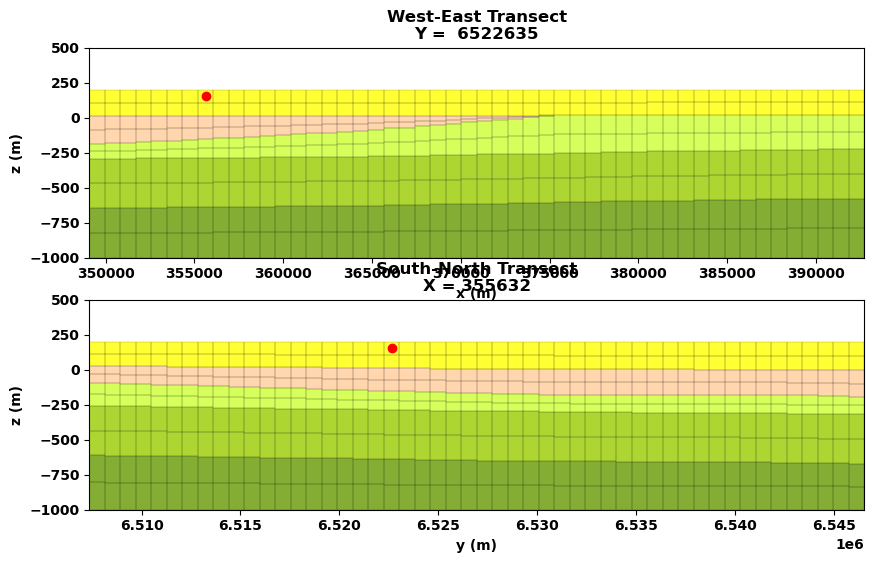

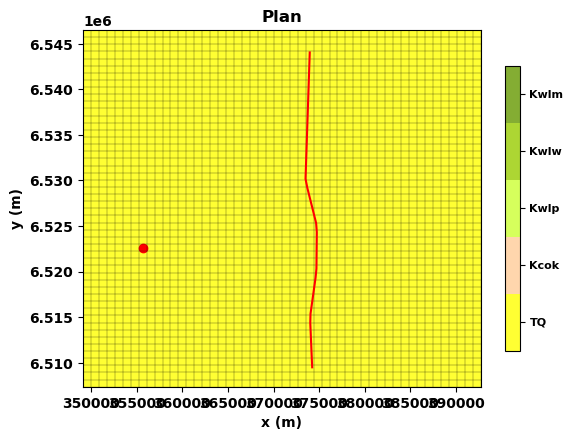

In [72]:
# IF A PROBLEM NODE FROM MFSIM, CAN LOT LOCATION HERE!
utils.plot_node(1508-1, geomodel, structuralmodel, spatial, sim, scenario, z1 = 500, features = ['fault'])

### TO DO: SORT OUT IDOMAIN FOR STRUCTURED GRIDS

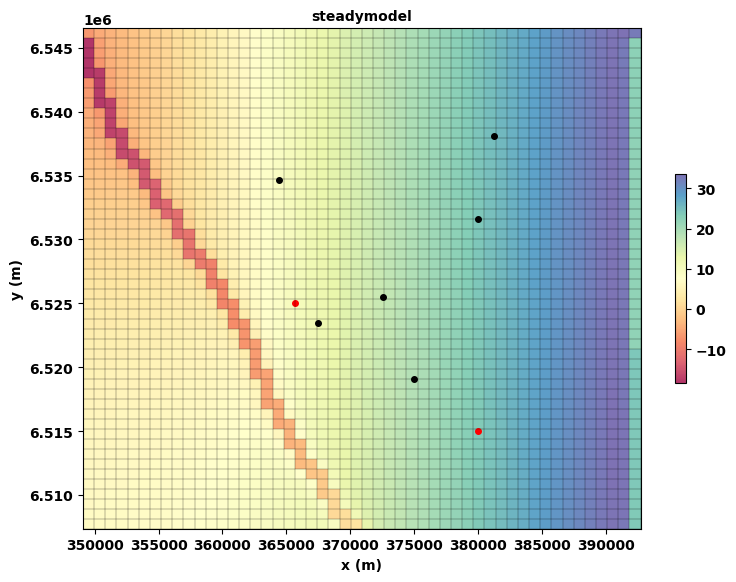

In [73]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable,)#, extent, vmin, vmax

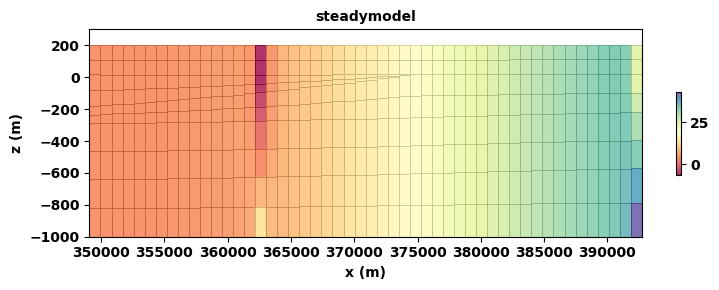

In [74]:
fm.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)

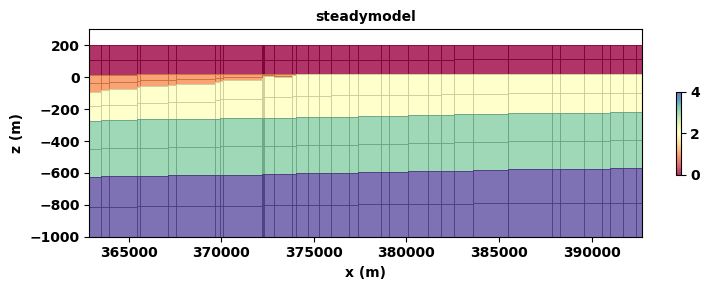

In [27]:
fm.plot_transect(spatial, structuralmodel, 'lith', y0 = 6520000, y1 = 6520000)

In [28]:
obj = fm
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

Methods in the class:   ['get_watertable', 'plot_plan', 'plot_transect', 'plot_watertable', 'run_flowmodel', 'write_flowmodel']

Attributes in the class:   ['chd', 'chdflow', 'data', 'disu_gridprops', 'evt', 'geomodel', 'gwf', 'head', 'lith', 'logk11', 'logk33', 'mesh', 'newtonoptions', 'obs', 'obsdata', 'observations', 'project', 'rch', 'runtime', 'scenario', 'spd', 'staggered', 'wel', 'xt3d']


### 9. Create and run transient flow model

In [29]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fm.head
fm2 = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
fm2.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

Well screens  [(np.float64(-1000.0), np.float64(26.0)), (np.float64(-1000.0), np.float64(8.0))]


In [31]:
sim = fm2.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True, evt = False)

   Writing simulation and gwf for  transientmodel  ...
xt3d =  True
mf6 executable expected:  ../exe/mf6.exe
   Time taken to write flow model =  4.397993


In [32]:
fm2.run_flowmodel(sim, transient = True)

Running simulation for  transientmodel  ...
Model success =  True
   run_time =  5.596279
['DISU', 'NPF', 'IC', 'STO', 'WEL_0', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 12066)


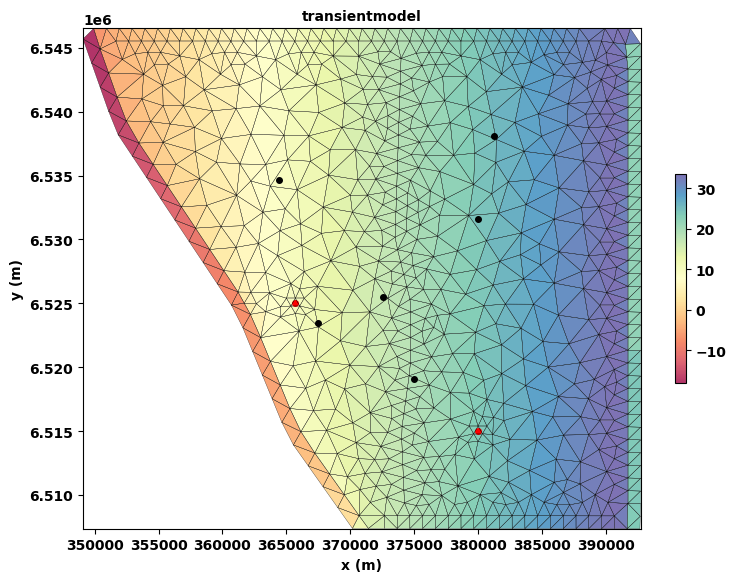

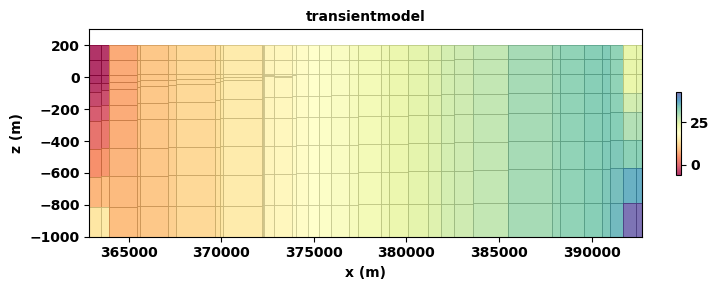

In [33]:
watertable = fm2.get_watertable(geomodel, fm2.head)
fm2.plot_watertable(spatial, mesh, geomodel, fm2, watertable,)#, extent, vmin, vmax
fm2.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)